# Wide and Deep Model for Amazon Products Recommendation

<br>

A linear model with a wide set of crossed-column (co-occurrence) features can memorize the feature interactions, while deep neural networks (DNN) can generalize the feature patterns through low-dimensional dense embeddings learned for the sparse features. 

[**Wide-and-deep**](https://arxiv.org/abs/1606.07792) learning jointly trains wide linear model and deep neural networks to combine the benefits of memorization and generalization for recommender systems.

This notebook shows how to build and test the wide-and-deep model using [TensorFlow high-level Estimator API](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNLinearCombinedRegressor). With the [movie recommendation dataset](https://grouplens.org/datasets/movielens/), we quickly demonstrate following topics:
1. How to prepare data
2. Build the model
3. Use log-hook to estimate performance while training
4. Test the model and export

In [1]:
import sys
sys.path.append('../../')

In [2]:
import itertools
import math
import os
from tempfile import TemporaryDirectory

import numpy as np
import scrapbook as sb
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf

tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL, # userID
    DEFAULT_ITEM_COL as ITEM_COL, # itemID
    DEFAULT_RATING_COL as RATING_COL, # rating
    DEFAULT_PREDICTION_COL as PREDICT_COL, # prediction
    DEFAULT_GENRE_COL as ITEM_FEAT_COL, # features
    SEED,
    DEFAULT_K,
    DEFAULT_THRESHOLD
)

from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets import movielens
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep

print("Tensorflow Version:", tf.__version__)
print("GPUs:\n", gpu_utils.get_gpu_info())
# tf.config.set_visible_devices([], 'GPU') # force to run on CPU

Tensorflow Version: 2.8.0
GPUs:
 [{'device_name': 'NVIDIA GeForce RTX 3070', 'total_memory': 7982.3125, 'free_memory': 7365.6875}, {'device_name': 'NVIDIA GeForce RTX 3070', 'total_memory': 7982.3125, 'free_memory': 7816.0625}]


In [3]:
"""Parameters"""

# Recommend top k items
TOP_K = 10

# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]

RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]

# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True

RANDOM_SEED = SEED  # Set seed for deterministic result

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = '/home/shiv/Documents/DataScience/Capstone/Data/'
EXPORT_DIR_BASE = './outputs/model'

# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR = None

#### Hyperparameters
MODEL_TYPE = 'wide_deep'
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32

# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = 'adagrad'
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer

# DNN model hyperparameters
DNN_OPTIMIZER = 'adadelta'
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer

# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

### 1. Prepare Data

#### 1.1 Amazon reviews and Amazon meta data

In [4]:
ratings_df = pd.read_csv(DATA_DIR + 'wide_deep_amzn_e_20.csv', header=None, low_memory=False)

In [5]:
ratings_df.columns=['userID','itemID', 'rating','genre','unixTimeStamp','title','price','main_cat','category']
ratings_df['category'].fillna('', inplace=True)
ratings_df['price'].fillna('$$$', inplace=True)
ratings_df.head()

,userID,itemID,rating,genre,unixTimeStamp,title,price,main_cat,category
0,0,0,5.0,Portable Audio & Accessories,1424217600,Kastar 2-Pack Replacement Battery for Midland ...,$15.99,Portable Audio & Accessories,
1,1,0,5.0,Portable Audio & Accessories,1422662400,Kastar 2-Pack Replacement Battery for Midland ...,$15.99,Portable Audio & Accessories,
2,2,0,5.0,Portable Audio & Accessories,1477612800,Kastar 2-Pack Replacement Battery for Midland ...,$15.99,Portable Audio & Accessories,
3,3,0,5.0,Portable Audio & Accessories,1476316800,Kastar 2-Pack Replacement Battery for Midland ...,$15.99,Portable Audio & Accessories,
4,4,0,5.0,Portable Audio & Accessories,1474156800,Kastar 2-Pack Replacement Battery for Midland ...,$15.99,Portable Audio & Accessories,


In [6]:
ratings_df = ratings_df[['userID','itemID','rating','genre']]

#### 1.2 Encode Item Features (Genres)
To use genres from our model, we multi-hot-encode them with scikit-learn's [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html).

For example, *Movie id=2355* has three genres, *Animation|Children's|Comedy*, which are being converted into an integer array of the indicator value for each genre like `[0, 0, 1, 1, 1, 0, 0, 0, ...]`. In the later step, we convert this into a float array and feed into the model.

> For faster feature encoding, you may load ratings and items separately (by using `movielens.load_item_df`), encode the item-features, then combine the rating and item dataframes by using join-operation. 

In [7]:
# Encode 'genres' into int array (multi-hot representation) to use as item features
genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
ratings_df[ITEM_FEAT_COL] = genres_encoder.fit_transform(
    ratings_df[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
).tolist()

print("Genres:", genres_encoder.classes_)
print("Num genres:", len(genres_encoder.classes_))

Genres: ['Accessories' 'Accessories & Supplies' 'All Electronics' 'Amazon Devices'
 'Apple Products' 'Audio & Video Accessories' 'Automotive'
 'Camera & Photo' 'Car & Vehicle Electronics' 'Car Electronics'
 'Cell Phones & Accessories' 'Clothing, Shoes & Jewelry'
 'Computer Accessories & Peripherals' 'Computer Components' 'Computers'
 'Computers & Accessories' 'Controllers' 'Electrical' 'Electronics'
 'GPS & Navigation' 'Home & Kitchen' 'Home Audio' 'Home Audio & Theater'
 'Industrial & Scientific' 'Laptop Accessories' 'Musical Instruments'
 'Office & School Supplies' 'Office Electronics' 'Office Products'
 'Portable Audio & Accessories' 'Portable Audio & Video'
 'Sports & Fitness' 'Sports & Outdoors' 'Tools & Home Improvement'
 'Toys & Games' 'Video Games']
Num genres: 36


#### 1.3 Train and Test Split

In [8]:
train, test = python_random_split(ratings_df, ratio=0.75, seed=RANDOM_SEED)

print("{} train samples and {} test samples".format(len(train), len(test)))

4209887 train samples and 1403296 test samples


<a id="users_items"></a>
#### Generate users and items datasets

In [9]:
# Unique items in the dataset
print(ratings_df.shape)
items = ratings_df.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
print(items.shape)
item_feat_shape = len(items[ITEM_FEAT_COL][0])
print(item_feat_shape) # number of genres

(5613183, 4)
(63725, 2)
36


In [10]:
# Unique users in the dataset
users = ratings_df.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 63725 items and 830668 users in the dataset


## [Jump to Model Serving](#model_serving) if we already have a pre-built model!

### 2. Build Model

Wide-and-deep model consists of a linear model and DNN. We use the following hyperparameters and feature sets for the model:

<br> | <div align="center">Wide (linear) model</div> | <div align="center">Deep neural networks</div>
---|---|---
Feature set | <ul><li>User-item co-occurrence features<br>to capture how their co-occurrence<br>correlates with the target rating</li></ul> | <ul><li>Deep, lower-dimensional embedding vectors<br>for every user and item</li><li>Item feature vector</li></ul>
Hyperparameters | <ul><li>FTRL optimizer</li><li>Learning rate = 0.0029</li><li>L1 regularization = 0.0</li></ul> | <ul><li>Adagrad optimizer</li><li>Learning rate = 0.1</li><li>Hidden units = [128, 256, 32]</li><li>Dropout rate = 0.4</li><li>Use batch normalization (Batch size = 64)</li><li>User embedding vector size = 4</li><li>Item embedding vector size = 4</li></ul>

<br>

* [FTRL optimizer](https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf)
* [Adagrad optimizer](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

Note, the hyperparameters are optimized for the training set. We used **Azure Machine Learning service** ([AzureML](https://azure.microsoft.com/en-us/services/machine-learning-service/)) to find the best hyperparameters, where we further split the training set into two subsets for training and validation respectively so that the test set is being separated from the tuning and training phases. For more details, see [azureml_hyperdrive_wide_and_deep.ipynb](../04_model_select_and_optimize/azureml_hyperdrive_wide_and_deep.ipynb).

In [12]:
STEPS=1000000

In [13]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 10) # STEPS = 50000
TMP_DIR = TemporaryDirectory()
model_dir = TMP_DIR.name
print(model_dir)

/tmp/tmpelq7y_mc


In [14]:
# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL, # userID
    item_col=ITEM_COL, # itemID
    item_feat_col=ITEM_FEAT_COL, # genre
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM, # 32
    item_dim=DNN_ITEM_DIM, # 16
    item_feat_shape=item_feat_shape, # 19
    model_type=MODEL_TYPE,  # 'wide_deep'
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userID', vocabulary_list=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...
	 VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userID', vocabulary_list=(0, 1, 2, 3, 4, 5, ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userID', vocabulary_list=(0, ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(0, ...
	 NumericColumn(key='genre', shape=(36,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


In [15]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG, # 0.0
        'l2_regularization_strength': LINEAR_L2_REG, # 0.0
        'momentum': LINEAR_MOMENTUM,  # 0.0
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG, # 0.0
        'l2_regularization_strength': DNN_L2_REG, # 0.0
        'momentum': DNN_MOMENTUM,  # 0.0
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS, # [64, 128, 512]
    dnn_dropout=DNN_DROPOUT, # 0.8
    dnn_batch_norm=(DNN_BATCH_NORM==1), # DNN_BATCH_NORM = 1
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED # 42
)

### 3. Train and Evaluate Model

Now we are all set to train the model. Here, we show how to utilize session hooks to track model performance while training. Our custom hook `tf_utils.evaluation_log_hook` estimates the model performance on the given data based on the specified evaluation functions. Note we pass test set to evaluate the model on rating metrics while we use <span id="ranking-pool">ranking-pool (all the user-item pairs)</span> for ranking metrics.

> Note: The TensorFlow Estimator's default loss calculates Mean Squared Error. Square root of the loss is the same as [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

## Notes

- We cannot prepare ranking evaluation set. The memory requirement is simply too big.
- E.g. for 1_000_000 users and 50_000 items, we would need 50 GB of memory
- Without the ranking pool, we cannot use ndcg@k or precision@k ranking metric

In [16]:
cols = {
    'col_user': USER_COL, # "userID"
    'col_item': ITEM_COL, # "itemID"
    'col_rating': RATING_COL, # "rating"
    'col_prediction': PREDICT_COL, # "prediction"
}
ranking_pool = None
# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
# ranking_pool = user_item_pairs(
#     user_df=users,
#     item_df=items,
#     user_col=USER_COL,
#     item_col=ITEM_COL,
#     user_item_filter_df=train,  # Remove seen items; train: userID, itemID, rating, genre
#     shuffle=False,
#     seed=RANDOM_SEED
# )
# ranking_pool has 1682X983 - 75_000 = 1_511_126 cartesian product
# 6040 x 3706 - 750156 = 21634084

In [19]:
# for metrics in (RANKING_METRICS, RATING_METRICS):
#     print(metrics)

In [17]:
# Define training hooks to track performance while training
# ndcg: Normalized Discounted Cumulative Gain
hooks = []
if EVALUATE_WHILE_TRAINING: # True
    evaluation_logger = tf_utils.MetricsLogger()
#     for metrics in (RANKING_METRICS, RATING_METRICS): # ndcg_at_k, precision_at_k; rmse, mae
#         if len(metrics) > 0:
    hooks.append(
        tf_utils.evaluation_log_hook(
            model,
            logger=evaluation_logger,
            true_df=test,
            y_col=RATING_COL,
#             eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
            eval_df=test.drop(RATING_COL, axis=1),
            every_n_iter=save_checkpoints_steps,
            model_dir=model_dir,
#                     eval_fns=[evaluator.metrics[m] for m in metrics],
            eval_fns=[evaluator.metrics[metrics] for metrics in RATING_METRICS],
#             **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
            **(cols)
        )
    )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

Let's train the model.

In [18]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.compat.v1.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 1000000, Batch size = 32 (num epochs = 7)
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Colocations handled automatically by placer.


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.


2022-08-01 15:32:25.068376: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 15:32:25.803186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 15:32:25.804343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpelq7y_mc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


2022-08-01 15:33:11.765537: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-08-01 15:33:16.809980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 15:33:16.810185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:loss = 689.2922, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100000...
INFO:tensorflow:Saving checkpoints for 100000 into /tmp/tmpelq7y_mc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100000...
INFO:tensorflow:global_step/sec: 104.552


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(
2022-08-01 15:49:13.227980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 15:49:13.228168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:loss = 24.614544, step = 100000 (971.602 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200000...
INFO:tensorflow:Saving checkpoints for 200000 into /tmp/tmpelq7y_mc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200000...
INFO:tensorflow:global_step/sec: 108.418


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(
2022-08-01 16:04:35.542443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 16:04:35.542646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:loss = 38.00202, step = 200000 (923.090 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300000...
INFO:tensorflow:Saving checkpoints for 300000 into /tmp/tmpelq7y_mc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300000...
INFO:tensorflow:global_step/sec: 91.7793


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(
2022-08-01 16:22:45.067243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 16:22:45.067446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:loss = 44.724503, step = 300000 (1087.890 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 400000...
INFO:tensorflow:Saving checkpoints for 400000 into /tmp/tmpelq7y_mc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 400000...
INFO:tensorflow:global_step/sec: 115.27


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(
2022-08-01 16:37:12.703774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 16:37:12.703974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:loss = 58.78936, step = 400000 (866.390 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500000...
INFO:tensorflow:Saving checkpoints for 500000 into /tmp/tmpelq7y_mc/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500000...
INFO:tensorflow:global_step/sec: 90.8427


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(
2022-08-01 16:55:33.376569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 16:55:33.376775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:loss = 20.139492, step = 500000 (1103.844 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600000...
INFO:tensorflow:Saving checkpoints for 600000 into /tmp/tmpelq7y_mc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600000...
INFO:tensorflow:global_step/sec: 91.7013


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(
2022-08-01 17:13:43.887768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 17:13:43.887969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:loss = 27.898827, step = 600000 (1089.256 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 700000...
INFO:tensorflow:Saving checkpoints for 700000 into /tmp/tmpelq7y_mc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 700000...
INFO:tensorflow:global_step/sec: 91.3655


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(
2022-08-01 17:31:58.825113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 17:31:58.825296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:loss = 28.18411, step = 700000 (1095.600 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 800000...
INFO:tensorflow:Saving checkpoints for 800000 into /tmp/tmpelq7y_mc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 800000...
INFO:tensorflow:global_step/sec: 98.5087


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(
2022-08-01 17:48:53.846314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 17:48:53.846524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:loss = 27.919865, step = 800000 (1012.857 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900000...
INFO:tensorflow:Saving checkpoints for 900000 into /tmp/tmpelq7y_mc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900000...
INFO:tensorflow:global_step/sec: 105.89


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(
2022-08-01 18:04:37.905820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 18:04:37.906021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:loss = 16.981068, step = 900000 (938.420 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000000...
INFO:tensorflow:Saving checkpoints for 1000000 into /tmp/tmpelq7y_mc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000000...
INFO:tensorflow:Loss for final step: 25.884441.


In [19]:
logs = evaluation_logger.get_log()
logs

{'rmse': [4.560691371843296,
  1.097325716796562,
  1.0777041280600417,
  1.0702420787639841,
  1.0652975836798118,
  1.063317462395253,
  1.060942881146609,
  1.059553989867443,
  1.0584321014068874,
  1.057801120217181],
 'mae': [4.414920451895229,
  0.8618665845426546,
  0.8118637643674194,
  0.7971600603018356,
  0.7828303697282187,
  0.7874117839124775,
  0.7746461160293763,
  0.7682480634140209,
  0.7663158783404408,
  0.7638086217996314]}

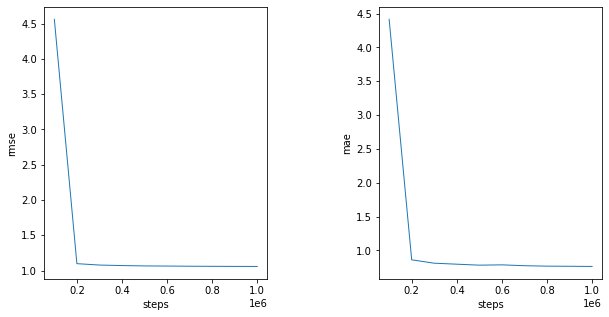

In [20]:
import scrapbook as sb
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        sb.glue("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

#### 3.2 TensorBoard

Once the train is done, you can browse the details of the training results as well as the metrics we logged from [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard).

[]()|[]()|[]()
:---:|:---:|:---:
<img src="https://recodatasets.z20.web.core.windows.net/images/tensorboard_0.png?sanitize=true"> |  <img src="https://recodatasets.z20.web.core.windows.net/images/tensorboard_1.png?sanitize=true"> | <img src="https://recodatasets.z20.web.core.windows.net/images/tensorboard_2.png?sanitize=true">

To open the TensorBoard, open a terminal from the same directory of this notebook, run `tensorboard --logdir=model_checkpoints`, and open http://localhost:6006 from a browser.



### 4. Test and Export Model

#### 4.1 Item rating prediction

In [21]:
if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.


/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpelq7y_mc/model.ckpt-1000000
INFO:tensorflow:Running local_init_op.


2022-08-01 18:23:04.436751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 18:23:04.436942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


INFO:tensorflow:Done running local_init_op.


{'rmse': 1.0574871868401199, 'mae': 0.7618798790135353}


#### 4.2 Recommend k items
For top-k recommendation evaluation, we use the ranking pool (all the user-item pairs) we prepared at the [training step](#ranking-pool). 

The difference is we remove users' seen items from the pool in this step which is more natural to the movie recommendation scenario.

### Notes:
- We cannot run this step as we do not have a ranking pool.
- Jump to the [model serving step](#model_serving) to calculate ranking metric when we cannot build a ranking pool.

In [22]:
ranking_pool = None

if ranking_pool is not None and len(RANKING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

    ranking_results = {}
    for m in RANKING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **{**cols, 'k': TOP_K}) # TOP_K = 10
        sb.glue(m, result)
        ranking_results[m] = result
    print(ranking_results)

#### 4.3 Export Model
Finally, we export the model so that we can load later for re-training, evaluation, and prediction.
Examples of how to load, re-train, and evaluate the saved model can be found from [azureml_hyperdrive_wide_and_deep.ipynb](../04_model_select_and_optimize/azureml_hyperdrive_wide_and_deep.ipynb) notebook.

In [23]:
os.makedirs(EXPORT_DIR_BASE, exist_ok=True)

In [24]:
exported_path = tf_utils.export_model(
    model=model,
    train_input_fn=train_fn,
    eval_input_fn=tf_utils.pandas_input_fn(
        df=test, y_col=RATING_COL
    ),
    tf_feat_cols=wide_columns+deep_columns,
    base_dir=EXPORT_DIR_BASE
)
sb.glue('saved_model_dir', str(exported_path))
print("Model exported to", str(exported_path))

/home/shiv/anaconda3/envs/RecSys_39/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(
2022-08-01 18:25:26.877366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 18:25:26.877560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6
2022-08-01 18:25:29.761346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5633 MB memory:  -> device: 0, na

Model exported to ./outputs/model/1659403524


In [25]:
# Close the event file so that the model folder can be cleaned up.
summary_writer = tf.compat.v1.summary.FileWriterCache.get(model.model_dir)
summary_writer.close()

# Cleanup temporary directory if used
if TMP_DIR is not None:
    TMP_DIR.cleanup()

<a id="model_serving"></a>
# Model Serving

- If running test set's rating, must restart the kernel and disable GPU
- If running ranking, then no need to restart, but a restart does no harm.
- Run the notebook till the generation of [users, items dataframes](#users_items) and jump to this cell.

In [11]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': 'prediction'
}

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [12]:
MODEL_DIR = './outputs/model/1659403524'

saved_model = tf.saved_model.load(MODEL_DIR, tags="serve")

2022-08-01 18:39:44.550481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 18:39:45.021353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-08-01 18:39:45.021882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6


# Rating metrics (rmse, mae) on test set (won't run on GPU)

- Must run on CPU as it will try to create a 3.5Mx512 byte array on GPU running out of memory.

In [ ]:
# Make sure you run this cell on CPU
X_test = test.drop(RATING_COL, axis=1)
X_test.reset_index(drop=True, inplace=True)

# Rating prediction
predictions = saved_model.signatures["predict"](
        examples=tf_utils.pandas_input_fn_for_saved_model(
            df=X_test,
            feat_name_type={
                USER_COL: int,
                ITEM_COL: int,
                ITEM_FEAT_COL: list
            }
        )()["inputs"]
    )

prediction_df = X_test.copy()
# prediction_df['prediction'] = [p['outputs'][0] for p in predictions]
prediction_df['prediction'] = predictions['predictions'].numpy()
print(prediction_df['prediction'].describe(), "\n")
for m in RATING_METRICS:
    result = evaluator.metrics[m](test, prediction_df, **cols)
    print(m, "=", result)

# Ranking metrics (ndcg@k, precision@k)

- Can run on GPU  but it is slow (proportional to the number of users)

In [13]:
def ndcg_at_k_one_user(rating_true, rating_pred,
                       col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL,
                       col_prediction=PREDICT_COL, relevancy_method="top_k", k=DEFAULT_K,
                       threshold=DEFAULT_THRESHOLD):
    df_hit, df_hit_count, n_users = evaluator.merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )
    assert(n_users==1)
    return df_hit, df_hit_count

In [14]:
# must ignore items already seen (makes sense for movies but Amazon products???)
all_items_set = set(items[ITEM_COL].values)

# no point of running ranking if a userID is not present in test
all_users_test = set(test[USER_COL].values)

In [16]:
from tqdm import tqdm

df_hit_master = pd.DataFrame(columns=[USER_COL, ITEM_COL, "rank"])
df_hit_count_master = pd.DataFrame(columns=[USER_COL, "hit", "actual"])

num_users = 0
k = 10000 # something big to test without training the model for a very long time!

for user in (pbar := tqdm(users[USER_COL])): # requires Python 3.8 walrus operator
    if user not in all_users_test:
        continue
    # print(user)
    
    tmp_df = train[train[USER_COL]==user]  # remove seen items
    items_rated = tmp_df[ITEM_COL].values
    items_rated_set = set(items_rated)
    if len(items_rated_set) < 100: # only include users who have rated at least 100 items
        continue
    
    items_not_seen = all_items_set - items_rated_set
    lst_items_not_seen = list(items_not_seen)
    
    len_lst = len(lst_items_not_seen)
    tmp_df = items[items[ITEM_COL].isin(lst_items_not_seen)]
    test_dict = {USER_COL:[user]*len_lst,
                 ITEM_COL:lst_items_not_seen,
                 ITEM_FEAT_COL:tmp_df[ITEM_FEAT_COL].values}
    # print(len(items_rated_set), len(items_not_seen))

    X_test = pd.DataFrame(test_dict)
    # Rating prediction
    predictions = saved_model.signatures["predict"](
            examples=tf_utils.pandas_input_fn_for_saved_model(
                df=X_test,
                feat_name_type={
                    USER_COL: int,
                    ITEM_COL: int,
                    ITEM_FEAT_COL: list
                }
            )()["inputs"]
        )

    prediction_df = X_test.copy()
    # prediction_df['prediction'] = [p['outputs'][0] for p in predictions]
    prediction_df['prediction'] = predictions['predictions'].numpy()
    
    df_hit_user, df_hit_count_user = ndcg_at_k_one_user(test, prediction_df, k=k)
    df_hit_master = pd.concat([df_hit_master, df_hit_user])
    df_hit_count_master = pd.concat([df_hit_count_master, df_hit_count_user])
    
    num_users += 1
    pbar.set_description(f'#users {num_users}')

100%|█████████████████████████████████████████████████████████████████████████████████████████| 830668/830668 [24:21<00:00, 568.36it/s]


## ndcg@k, precision@k

In [18]:
n_users = num_users

# calculate discounted gain for hit items
df_dcg = df_hit_master.copy()
# relevance in this case is always 1
df_dcg["dcg"] = 1 / np.log1p(df_dcg["rank"].astype('float32'))
# sum up discount gained to get discount cumulative gain
df_dcg = df_dcg.groupby(USER_COL, as_index=False, sort=False).agg({"dcg": "sum"})

# calculate ideal discounted cumulative gain
df_ndcg = pd.merge(df_dcg, df_hit_count_master, on=[USER_COL])
df_ndcg["idcg"] = df_ndcg["actual"].apply(
    lambda x: sum(1 / np.log1p(range(1, min(x, k) + 1)))
)

# DCG over IDCG is the normalized DCG
(df_ndcg["dcg"] / df_ndcg["idcg"]).sum() / n_users

0.0719124581920513

In [19]:
# Precision @ k
(df_hit_count_master["hit"] / k).sum() / n_users

0.0009674418604651162